<a href="https://colab.research.google.com/github/Toomishe/Multi-Stage-Classification-of-Retinal-OCT-using-Multi-Scale-Ensemble-Deep-Architecture/blob/main/Multi_3_classes_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTING PYTHON LIBRARIES

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import *
from keras.models import *
import os
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.densenet import preprocess_input
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Model
from pickle import dump

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
import random
from PIL import Image
import os

import random
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd




# MULTICLASS ON MULTI SCALE 3 CLASSES

In [ ]:
#Load model wIthout classifier/fully connected layers
base_modelM = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='max',
    classes=3,
    classifier_activation=None  ,
)

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in base_modelM.layers:
    layer.trainable = False
# base_modelM.summary()

In [ ]:
# lOADING TRAIN DATA FOR MULTICLASS
directory = "D:/OCT Classification Project/Datasets/OCT Image/OCT2017/train - Copy"

TRX224 = []
TRY224 = []
TRX112 =[]
TRY112 = []
TRX56 = []
TRY56 = []


for folder in os.listdir(directory):
    image_lists = os.listdir(directory+'\\'+folder)
#     print(image_lists)
    for i in range(2400):
        index = random.randint(0,8500)
        image = image_lists[index]
        x = image[:6]
        y = image[:3]
        img = os.path.join(directory,folder,image)
#         print(img)
        Images = cv2.imread(img)

        # LOADING 224
        Images_224 = cv2.resize(Images, (224, 224), interpolation = cv2.INTER_AREA)

        #normalize the data set
        Images_224 = Images_224/255

        TRX224.append(Images_224)

        if x == "NORMAL":
            TRY224.append('NORMAL')
        elif y == "CNV":
            TRY224.append('CNV')
        elif y == "DME":
            TRY224.append('DME')
        elif x == "DRUSEN":
            TRY224.append('DRUSEN')



        #LOADING 112
        Images_112 = cv2.resize(Images, (112, 112), interpolation = cv2.INTER_AREA)

        #normalize the data set
        Images_112 = Images_112/255

        TRX112.append(Images_112)

        if x == "NORMAL":
            TRY112.append('NORMAL')
        elif y == "CNV":
            TRY112.append('CNV')
        elif y == "DME":
            TRY112.append('DME')
        elif x == "DRUSEN":
            TRY112.append('DRUSEN')


        #LOADING 56
        Images_56 = cv2.resize(Images, (56, 56), interpolation = cv2.INTER_AREA)

        #normalize the data set
        Images_56 = Images_56/255

        TRX56.append(Images_56)

        if x == "NORMAL":
            TRY56.append('NORMAL')
        elif y == "CNV":
            TRY56.append('CNV')
        elif y == "DME":
            TRY56.append('DME')
        elif x == "DRUSEN":
            TRY56.append('DRUSEN')



In [ ]:
# Checking the unique of loaded data
np.unique(TRY224)

array(['CNV', 'DME', 'DRUSEN'], dtype='<U6')

In [ ]:
#CONVERTING INPUTS TO ARRAY
TRX224=np.array(TRX224)
TRY224=np.array(TRY224)

TRX112=np.array(TRX112)
TRY112=np.array(TRY112)

TRX56=np.array(TRX56)
TRY56=np.array(TRY56)

In [ ]:
# Encoding Y Label
le = LabelEncoder()
MY224 = le.fit_transform(TRY224)
MY112 = le.fit_transform(TRY112)
MY56 = le.fit_transform(TRY56)

In [ ]:
#extracting features from Train set for 112 sizes
TRX112_Ft=base_modelM.predict(TRX112)

#extracting features from Train set for 56 sizes
TRX56_Ft=base_modelM.predict(TRX56)

#extracting features from Train set for 224 sizes
TRX224_Ft=base_modelM.predict(TRX224)


225/225 [==============================] - 494s 2s/step


In [ ]:
#Concatenate features of all sizes
x = np.concatenate([TRX112_Ft, TRX56_Ft, TRX224_Ft], axis=1)

In [ ]:
# Building the MLP

modelCVM = Sequential()
modelCVM.add(Flatten(input_shape=(5760,)))
modelCVM.add(Dense(64, activation='relu'))
modelCVM.add(Dropout(0.5))
modelCVM.add(Dense(4, activation='softmax'))

In [ ]:
# Configure cross-validation

from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
fold = 1
accuracies = []
for train_index, test_index in kfold.split(x, MY224):
    print(f"Training on Fold {fold}...")

    # Split the data into training and validation sets for this fold
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = MY224[train_index], MY224[test_index]

    # Compile and train the CNN model
    modelCVM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelCVM.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    _, accuracy = modelCVM.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy on Fold {fold}: {accuracy}")
    accuracies.append(accuracy)

    fold += 1

Training on Fold 1...
Epoch 1/5
45/45 [==============================] - 1s 8ms/step - loss: 0.3155 - accuracy: 0.8474 - val_loss: 0.1023 - val_accuracy: 0.9618
Epoch 2/5
45/45 [==============================] - 0s 6ms/step - loss: 0.2828 - accuracy: 0.8595 - val_loss: 0.1106 - val_accuracy: 0.9576
Epoch 3/5
45/45 [==============================] - 0s 6ms/step - loss: 0.2619 - accuracy: 0.8764 - val_loss: 0.0969 - val_accuracy: 0.9674
Epoch 4/5
45/45 [==============================] - 0s 6ms/step - loss: 0.2795 - accuracy: 0.8583 - val_loss: 0.1106 - val_accuracy: 0.9653
Epoch 5/5
45/45 [==============================] - 0s 6ms/step - loss: 0.2882 - accuracy: 0.8566 - val_loss: 0.1271 - val_accuracy: 0.9569
Accuracy on Fold 1: 0.956944465637207
Training on Fold 2...
Epoch 1/5
45/45 [==============================] - 1s 8ms/step - loss: 0.3125 - accuracy: 0.8476 - val_loss: 0.1021 - val_accuracy: 0.9715
Epoch 2/5
45/45 [==============================] - 0s 6ms/step - loss: 0.2578 - accu

In [ ]:
# Compute the average cross-validation accuracy
avg_accuracy = np.mean(accuracies)
print("Average cross-validation accuracy:", avg_accuracy)

Average cross-validation accuracy: 0.9683333516120911


In [ ]:
# Compute the average cross-validation accuracy
std_accuracy = np.std(accuracies)
print("Std cross-validation accuracy:", std_accuracy)

Std cross-validation accuracy: 0.008021957489331415


In [ ]:

MSE_MC = metrics.mean_squared_error(y_test, Y_predMC)
print("MSE:", MSE_MC)


0.009027777777777777

In [ ]:
# Save model to disk
import joblib
joblib.dump(modelCVM, 'MULTI_3CLASSES_CV.pkl')

['MULTI_3CLASSES_CV.pkl']

In [ ]:
# Evaluate the model
test_lossMC, test_accMC = modelCVM.evaluate(X_test, y_test)
print('MLP Test accuracy MC:', test_accMC)

45/45 [==============================] - 0s 1ms/step - loss: 0.0633 - accuracy: 0.9778
DNN Test accuracy MC: 0.9777777791023254


In [ ]:
# # Evaluate the model method 2
# Y_predMC = modelCVM.predict(X_test).argmax(axis=1)

# print("MLP Accuracy MC: ", accuracy_score(y_test, Y_predMC))

45/45 [==============================] - 0s 974us/step
DNN Accuracy MC:  0.9777777777777777


In [ ]:
# # Evaluate the model 1
# test_lossMC, test_accMC = modelCVM.evaluate(ext_X, ext_Y)
# print('MLP Test accuracy MC:', test_accMC)

In [ ]:
# Plotting the confusion matrix

confusion_matrix(y_test, Y_predMC)

array([[436,   3,  12],
       [  1, 487,   9],
       [  4,   3, 485]], dtype=int64)

In [ ]:
# Plotting the classification report

from sklearn.metrics import classification_report
print(classification_report(y_test, Y_predMC))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       451
           1       1.00      1.00      1.00       497
           2       0.99      1.00      1.00       492

    accuracy                           1.00      1440
   macro avg       1.00      1.00      1.00      1440
weighted avg       1.00      1.00      1.00      1440



In [ ]:
# Calculate specificity and sensitivity USING MLP

def calculate_specificity(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    tn = sum(cm.diagonal()) - cm[class_label, class_label]
    fp = sum(cm[:, class_label]) - cm[class_label, class_label]
    specificity = tn / (tn + fp)
    return specificity

def calculate_overall_specificity(y_true, y_pred, num_classes):
    overall_specificity = 0.0
    for class_label in range(num_classes):
        specificity = calculate_specificity(y_true, y_pred, class_label)
        overall_specificity += specificity
        print("Specificity for class", class_label, ":", specificity)
    overall_specificity /= num_classes
    print("Overall specificity:", overall_specificity)
    model_listMC=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes']
    resultMC__ = pd.DataFrame ({"Model": model_listMC, "specificity":specificity, "overall":overall_specificity})

def calculate_sensitivity(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[class_label, class_label]
    fn = sum(cm[class_label, :]) - tp
    sensitivity = tp / (tp + fn)
    return sensitivity

def calculate_overall_sensitivity(y_true, y_pred, num_classes):
    overall_sensitivity = 0.0
    for class_label in range(num_classes):
        sensitivity = calculate_sensitivity(y_true, y_pred, class_label)
        overall_sensitivity += sensitivity
        print("Sensitivity for class", class_label, ":", sensitivity)
    overall_sensitivity /= num_classes
    print("Overall sensitivity:", overall_sensitivity)
    model_listMC=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes']
    resultMC__ = pd.DataFrame ({"Model": model_listMC, "sensitivity":sensitivity, "overall":overall_sensitivity})

calculate_overall_specificity(y_test, Y_predMC, 3)
calculate_overall_sensitivity(y_test, Y_predMC, 3)



Specificity for class 0 : 0.9948822927328557
Specificity for class 1 : 0.9935275080906149
Specificity for class 2 : 0.9777542372881356
Overall specificity: 0.9887213460372021
Sensitivity for class 0 : 0.9667405764966741
Sensitivity for class 1 : 0.9798792756539235
Sensitivity for class 2 : 0.9857723577235772
Overall sensitivity: 0.9774640699580583


In [ ]:
# machine learning model_pipeline for different classifiers

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn. tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append (SVC(probability=True))
model_pipeline.append(DecisionTreeClassifier ())
model_pipeline.append(RandomForestClassifier ())
model_pipeline.append(GaussianNB ( ))

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score


model_listMC=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes']

acc_listMC = []
cm_listMC = []
MSEMC = []
scores_avgMC = []
scores_stdMC = []

for model in model_pipeline:
  model.fit (X_train, y_train)
  MulClass_pred = model.predict (X_test)
  acc_listMC.append(metrics.accuracy_score(y_test, MulClass_pred))
  cm_listMC.append(confusion_matrix(y_test, MulClass_pred))
  MSEMC.append(mean_squared_error(y_test, MulClass_pred))
  scores_avgMC.append((cross_val_score(model, x, MY224, cv=5, scoring='f1_macro')).mean())
  scores_stdMC.append((cross_val_score(model, x, MY224, cv=5, scoring='f1_macro')).std())


resultMC = pd.DataFrame ({"Model": model_listMC, "Accuracy":acc_listMC, "MSE":MSEMC, "scores_avg":scores_avgMC, "scores_std":scores_stdMC})
# resultMC.append({'Model': 'DNN', "Accuracy":test_accMC, "MSE":MSE_MC},  ignore_index=True)

In [ ]:
resultMC.append({'Model': 'DNN', "Accuracy":test_accMC, "MSE":MSE_MC, "scores_avg": avg_accuracy, "scores_std" :std_accuracy},  ignore_index=True)

C:\Users\Akinniyi\AppData\Local\Temp\ipykernel_13800\1503254650.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultMC.append({'Model': 'DNN', "Accuracy":test_accMC, "MSE":MSE_MC, "scores_avg": avg_accuracy, "scores_std" :std_accuracy},  ignore_index=True)


,Model,Accuracy,MSE,scores_avg,scores_std
0,Logistic Regression,0.886806,0.246528,0.893357,0.009539
1,SVM,0.896528,0.234722,0.894690,0.013648
2,Decision Tree,0.679861,0.657639,0.699239,0.019689
3,Random Forest,0.846528,0.301389,0.846249,0.014035
4,Naive Bayes,0.674306,0.644444,0.674556,0.015720
5,DNN,0.977778,0.009028,0.968333,0.008022


In [ ]:
# Calculate specificity and sensitivity USING ALL CLASSIFIERS

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear', max_iter=10000))
model_pipeline.append (SVC(probability=True, max_iter=10000))
model_pipeline.append(DecisionTreeClassifier ())
model_pipeline.append(RandomForestClassifier ())
model_pipeline.append(GaussianNB ( ))
model_listMC=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes']

# specificityMC = []
# sensitivityMC = []

for model in model_pipeline:
  model.fit (X_train, y_train)
  MulClass_pred = model.predict (X_test)
  calculate_overall_specificity(y_test, MulClass_pred, 3)
  calculate_overall_sensitivity(y_test, MulClass_pred, 3)
# specificityMC.append(calculate_overall_specificity(Y_test, MulClass_pred, 4))
# sensitivityMC.append(calculate_overall_sensitivity(Y_test, MulClass_pred, 4))


# resultMC__ = pd.DataFrame ({"Model": model_listMC, "specificity":specificityMC, "sensitivity":sensitivityMC})

Specificity for class 0 : 0.9510337323177367
Specificity for class 1 : 0.9351535836177475
Specificity for class 2 : 0.9336235038084875
Overall specificity: 0.9399369399146572
Sensitivity for class 0 : 0.893569844789357
Sensitivity for class 1 : 0.9154929577464789
Sensitivity for class 2 : 0.8516260162601627
Overall sensitivity: 0.8868962729319995
Specificity for class 0 : 0.9453376205787781
Specificity for class 1 : 0.9579545454545455
Specificity for class 2 : 0.9335511982570807
Overall specificity: 0.9456144547634681
Sensitivity for class 0 : 0.9068736141906873
Sensitivity for class 1 : 0.9014084507042254
Sensitivity for class 2 : 0.8821138211382114
Overall sensitivity: 0.896798628677708
Specificity for class 0 : 0.804374240583232
Specificity for class 1 : 0.8146279949558638
Specificity for class 2 : 0.8312958435207825
Overall specificity: 0.8167660263532928
Sensitivity for class 0 : 0.7361419068736141
Sensitivity for class 1 : 0.7002012072434608
Sensitivity for class 2 : 0.6382113821

In [ ]:
# Ensemble of all Confusion Matrix

cm_listMC
cm_listMC.append(confusion_matrix(y_test, Y_predMC))
cm_listMC

In [ ]:
# # Error fix
# cm_listMC

# cm_listMC_ = np.delete(cm_listMC, 5, axis=0)
# cm_listMC_

# row_to_be_added = confusion_matrix(y_test, Y_predMC)
# #last row
# row_n = cm_listMC_.shape[0]
# cm_listMC__ = np.insert(cm_listMC_,row_n,[row_to_be_added],axis= 0)
# cm_listMC__

array([[[403,  18,  30],
        [ 11, 455,  31],
        [ 34,  39, 419]],

       [[409,  13,  29],
        [ 17, 448,  32],
        [ 34,  24, 434]],

       [[325,  61,  65],
        [ 66, 340,  91],
        [ 97,  81, 314]],

       [[394,  29,  28],
        [ 29, 421,  47],
        [ 43,  45, 404]],

       [[302,  45, 104],
        [ 45, 279, 173],
        [ 49,  53, 390]]], dtype=int64)

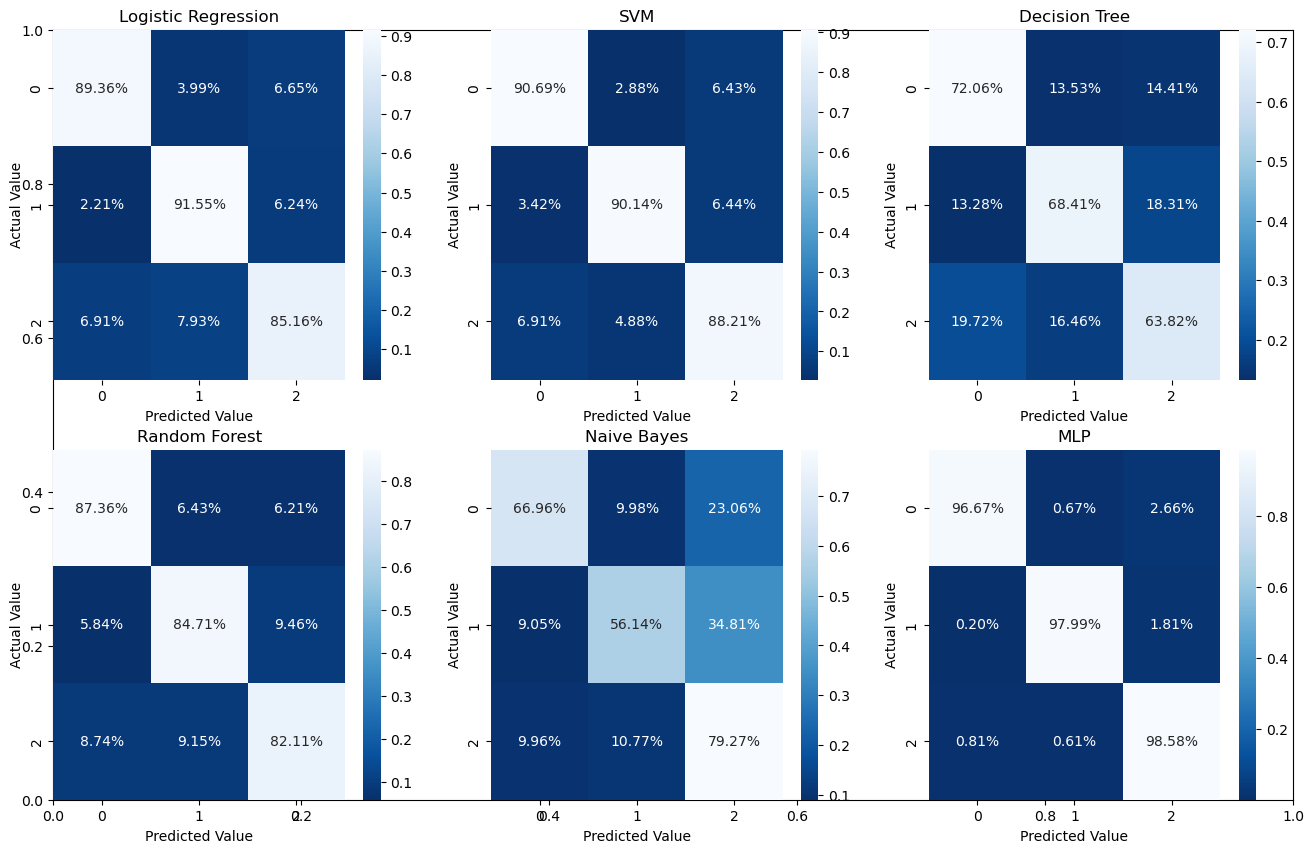

In [ ]:
# Plot confusion matrix
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(figsize=(16, 10))
model_list_all=["Logistic Regression", 'SVM', 'Decision Tree', 'Random Forest','Naive Bayes', 'MLP']
for i in range (len(cm_listMC)):
  cmMC=cm_listMC__[i]
  modelMC = model_list_all[i]
  sub=fig.add_subplot(2,3,i+1).set_title(modelMC)
  cm_sumMC = np.sum(cmMC, axis=1, keepdims=True)
#   cm_sumMC = np.sum(cmMC, axis=1, keepdims=True)
  cm_plotMC=sns.heatmap(cmMC/cm_sumMC.astype(float), annot=True,
            fmt='.2%', cmap='Blues_r')
  cm_plotMC.set_xlabel("Predicted Value")
  cm_plotMC.set_ylabel("Actual Value")

fig.savefig('confusion_matrix_3classes_CV.png')

# ROC CURVE MULTI CLASS

In [ ]:
#PLOTTING ROC CURVE FOR MULTICLASS

In [ ]:
# Identify unique label

label = np.unique(TRY224)
label

array(['CNV', 'DME', 'DRUSEN'], dtype='<U6')

In [ ]:
# Identify number of classes

classes = len(np.unique(TRY224))

In [ ]:
# One hot encode the labels

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
Y_onehot_test = label_binarizer.transform(y_test)
Y_onehot_test.shape  # (n_samples, n_classes)

(1440, 3)

In [ ]:
# check for encoding
label_binarizer.transform([0])

class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

array([[1, 0, 0]])

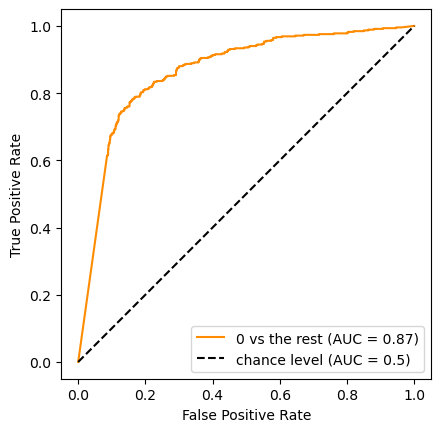

In [ ]:
# Plot OVR ROC FOR CLASSIFIER RESULTS

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

class_of_interest = 0

class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

Y_score = model.fit(X_train, y_train).predict_proba(X_test)

RocCurveDisplay.from_predictions(
    Y_onehot_test[:, class_id],
    Y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("One-vs-Rest ROC curves:\n DRUSEN vs (DME, CNV)")
plt.legend()
plt.show()


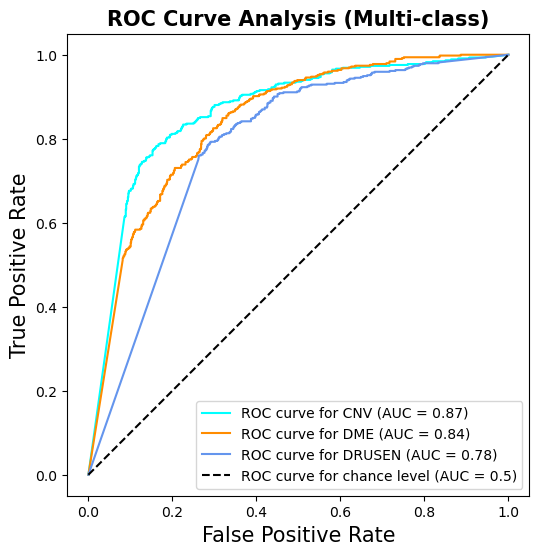

In [ ]:
# Plot ALL CLASSES ROC FOR CLASSIFIER RESULTS

from itertools import cycle

fig, ax = plt.subplots(figsize=(8, 6))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue"])
for class_id, color in zip(range(classes), colors):
    RocCurveDisplay.from_predictions(
        Y_onehot_test[:, class_id],
        Y_score[:, class_id],
        name=f"ROC curve for {label[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curve Analysis (Multi-class)", fontweight='bold', fontsize=15)
plt.legend()
plt.show()
fig.savefig('ROC_Curve_3class_CV.png')

45/45 [==============================] - 0s 884us/step


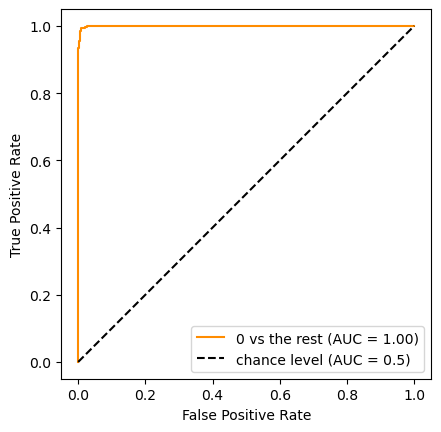

In [ ]:
# Plot OVR ROC FOR MLP RESULT

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

class_of_interest = 0

class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

Y_score_ = predicted_probabilities = modelCVM.predict(X_test)
Y_score_

# # Y_score = modelCVM.fit(X_train, y_train).predict_proba(X_test)

RocCurveDisplay.from_predictions(
    Y_onehot_test[:, class_id],
    Y_score_[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("One-vs-Rest ROC curves:\n DRUSEN vs (DME, CNV)")
plt.legend()
plt.show()


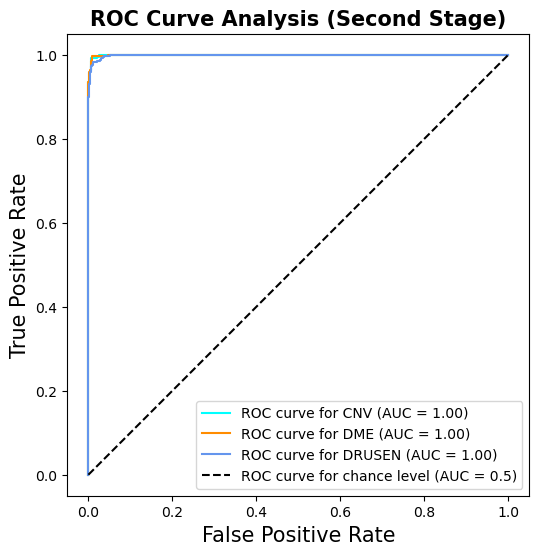

In [ ]:
# Plot ALL CLASSES ROC FOR MLP RESULT

from itertools import cycle

fig, ax = plt.subplots(figsize=(8, 6))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue"])
for class_id, color in zip(range(classes), colors):
    RocCurveDisplay.from_predictions(
        Y_onehot_test[:, class_id],
        Y_score_[:, class_id],
        name=f"ROC curve for {label[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curve Analysis (Second Stage)", fontweight='bold', fontsize=15)
plt.legend()
plt.show()
fig.savefig('ROC_Curve_3class_MLP_CV.png')